# American Options
## Least Square Monte Carlo Method

In [1]:
import yfinance as yf 
import numpy as np
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm

plt.style.use('bmh')

In [2]:
def simulate_gbm(S_0, mu, sigma, T, N, num_sim):
    dt = T/N
    dW = np.random.normal(scale=np.sqrt(dt), size=(num_sim, N))
    W = dW.cumsum(axis=1)
    time_steps = np.linspace(dt, T, N)
    S_t = S_0 * np.exp((mu - 0.5 * (sigma**2)) * time_steps + sigma * W)
    S_t = np.insert(S_t, 0, S_0, axis=1)
    
    return S_t

In [3]:
ticker = 'KO'
data = yf.download(ticker, period='10y', interval='1d', auto_adjust=True, progress=False)
data['returns'] = np.log(data.Close / data.Close.shift(1))
data.dropna(inplace=True)
data.tail()

,Open,High,Low,Close,Volume,returns
Date,,,,,,
2022-02-17,60.549999,62.279999,60.410000,62.119999,21468700,0.019835
2022-02-18,62.119999,62.820000,61.990002,62.540001,21968400,0.006738
2022-02-22,62.430000,62.639999,61.720001,62.279999,21731400,-0.004166
2022-02-23,62.240002,62.330002,61.340000,61.590000,19248500,-0.011141
2022-02-24,59.970001,60.619999,59.220001,60.509998,27149054,-0.017691


In [4]:
S_0 = data.Close[-1]
sigma = data.returns.std() * np.sqrt(252)
num_sim = 100_000
T = 1 # 1-year
N = 252 # 252 trading days
K = 60 # strike price
rf = 0.01 # risk-free rate
dt = T/N
discount_factor = np.exp(-rf * dt)

In [5]:
S_t = simulate_gbm(S_0, rf, sigma, T, N, num_sim)
S_t.shape

(100000, 253)

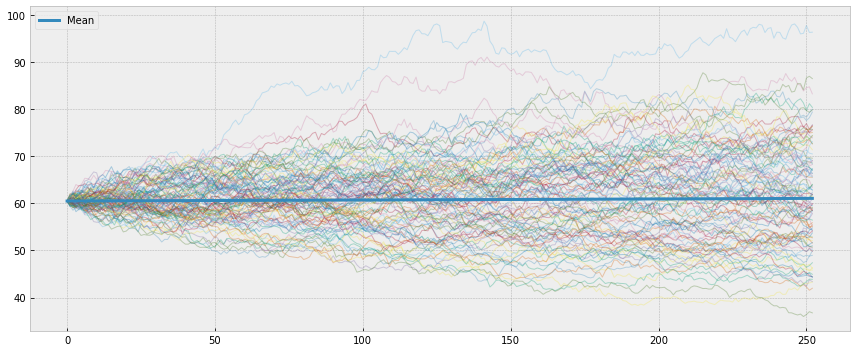

In [6]:
fig, ax = plt.subplots(figsize=(12,5))

ax.plot(S_t[:100].transpose(), alpha=0.3, linewidth=1)
ax.plot(S_t.mean(axis=0), label='Mean', linewidth=3)
ax.legend()

plt.tight_layout()
plt.show()

In [7]:
call_payoff = np.maximum(S_t - K, 0)
put_payoff = np.maximum(K - S_t, 0)

call_values = np.zeros_like(call_payoff)
put_values = np.zeros_like(put_payoff)

call_values[:, -1] = call_payoff[:, -1]
put_values[:, -1] = put_payoff[:, -1]

In [8]:
for t in tqdm(range(N-1, 0, -1)):
    # fit regression
    call_reg = np.polyfit(S_t[:, t], call_values[:, t+1] * discount_factor, 5)
    put_reg = np.polyfit(S_t[:, t], put_values[:, t+1] * discount_factor, 5)
    
    # get predictions
    call_continuation_val = np.polyval(call_reg, S_t[:, t])
    put_continuation_val = np.polyval(put_reg, S_t[:, t])
    
    # get option values
    # if payoff > predicted values --> set to payoff
    # else --> set to one-step ahead discounted values
    call_values[:, t] = np.where(call_payoff[:, t] > call_continuation_val,
                                    call_payoff[:, t], 
                                    call_values[:, t+1] * discount_factor)
    put_values[:, t] = np.where(put_payoff[:, t] > put_continuation_val,
                                   put_payoff[:, t], 
                                   put_values[:, t+1] * discount_factor)

  0%|          | 0/251 [00:00<?, ?it/s]

In [9]:
call_premium = (call_values[:, 1] * discount_factor).mean()
put_premium = (put_values[:, 1] * discount_factor).mean()

In [10]:
print(f"Strike Price: {K}")
print(f"Call premium: {call_premium:.4f}")
print(f"Put premium: {put_premium:.4f}")

Strike Price: 60
Call premium: 4.5917
Put premium: 3.6201
